In [44]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant, calc_Sqw_from_SpinW_results
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [46]:
cmap_mako = sns.color_palette("mako", as_cmap=True)

In [2]:
from inxss.experiment import SimulatedExperiment, NeutronExperiment

In [3]:
incident_energy = 260

In [4]:
q_grid = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Qlist_0.csv', delimiter=',')
w_grid_edges = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Elist_0.csv', delimiter=',')
w_grid = (w_grid_edges[1:] + w_grid_edges[:-1]) / 2

Syy = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Syy_withBroadening_0.csv', delimiter=',')
Szz = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Szz_withBroadening_0.csv', delimiter=',')
Sqw = torch.from_numpy(calc_Sqw_from_SpinW_results(q_grid, Syy, Szz))

In [5]:
data = torch.load(f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')

neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)

hklw_grid_norm = hklw_grid[...,:2].norm(dim=-1)
neutron_exp.prepare_experiment(hklw_grid)

In [6]:
sim_exp = SimulatedExperiment(q_grid, w_grid, Syy, Szz, neutron_flux=3e2)

In [7]:
s_pred = sim_exp.get_measurements_on_coords(hklw_grid).numpy()

In [232]:
# pearson_cc_sigma = []
_sigma = 1.25
s_pred_sm = gaussian_filter(s_pred, sigma=_sigma)
mask_exp = neutron_exp.Sqw > 1e-10
mask_pred = (s_pred_sm > 5e-2*s_pred_sm.max()) * mask_exp.cpu().numpy()
s_pred_masked = s_pred * mask_pred
s_pred_masked_sm = s_pred_sm * mask_pred

Sqw_exp_diag = np.diag(neutron_exp.Sqw.sum(-1).sum(-1) / (neutron_exp.Sqw > 1e-10).sum(-1).sum(-1))
Sqw_smh_diag = Sqw_exp_diag.max() * np.diag((s_pred_sm * mask_pred).sum(-1).sum(-1) / ((s_pred_sm * mask_pred).sum(-1).sum(-1)).max())

# pearson_cc_sigma.append(pearsonr(Sqw_exp_diag, Sqw_smh_diag).statistic)

# mask_pred = (s_pred > 1e-10*s_pred.max()) * mask_exp.cpu().numpy()
# s_pred_masked = s_pred * mask_pred
# s_pred_masked_sm = s_pred_sm * mask_pred

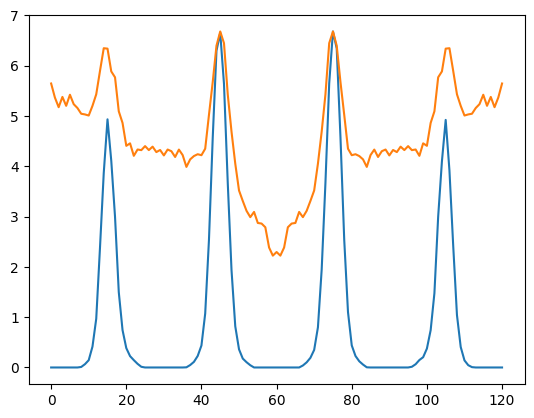

In [233]:
Sqw_exp_diag = np.diag(neutron_exp.Sqw.sum(-1).sum(-1) / (neutron_exp.Sqw > 1e-10).sum(-1).sum(-1))
Sqw_smh_diag = np.diag((s_pred_sm * mask_pred).sum(-1).sum(-1) / ((s_pred_sm * mask_pred).sum(-1).sum(-1)).max())
Sqw_smh_diag = Sqw_exp_diag.max() * Sqw_smh_diag / Sqw_smh_diag.max()
plt.plot(Sqw_smh_diag)
plt.plot(Sqw_exp_diag)

### setup neural network model

In [234]:
# model = SpecNeuralRepr.load_from_checkpoint(
#     '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896843/checkpoints/epoch=1165-step=55968.ckpt'
#     ).to(device)

# model = SpecNeuralRepr.load_from_checkpoint(
#     '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896844/checkpoints/epoch=1005-step=48288.ckpt'
#     )

In [235]:
# sqw_disp = neutron_exp.Sqw.sum(-1).sum(-1)
sqw_disp = neutron_exp.Sqw.sum(-1).sum(-1) / (neutron_exp.Sqw > 1).sum(-1).sum(-1)
# sqw_disp = data['S'].sum(-1).sum(-1) / (data['S'] > 1e-3).sum(-1).sum(-1)

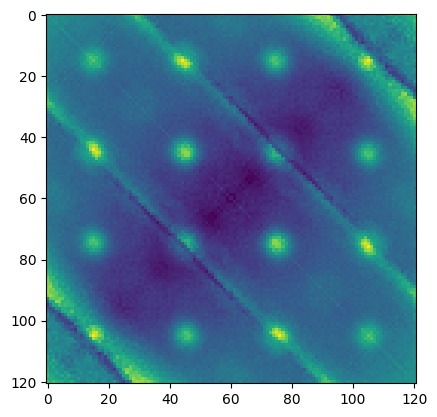

In [236]:
plt.imshow(sqw_disp)

In [237]:
# x_input = torch.zeros(hklw_grid.shape[:-1]+(5,))

# x_input[...,:3] = hklw_grid[...,[0,1,3]]
# x_input[...,3:] = torch.tensor([29.0, 1.68])

# s_pred = []
# k = 0
# with torch.no_grad():
#     for _x_input in tqdm(x_input.permute(3,0,1,2,4).reshape((-1, hklw_grid.shape[0], hklw_grid.shape[1], hklw_grid.shape[2], 5,))):
#         # print(_x_input.shape)
#         _y_output = model(_x_input.to(device), l=hklw_grid[...,k,[2]].to(device)).detach().cpu().numpy()
#         s_pred.append(_y_output)
#         k += 1
#         # break
# s_pred = np.moveaxis(np.stack(s_pred), 0, -1)

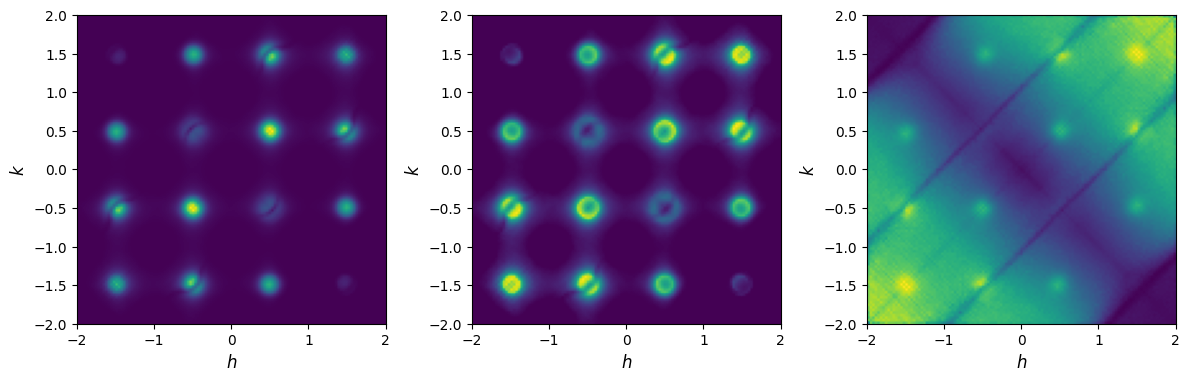

In [238]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked_sm.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow(mask_pred.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()


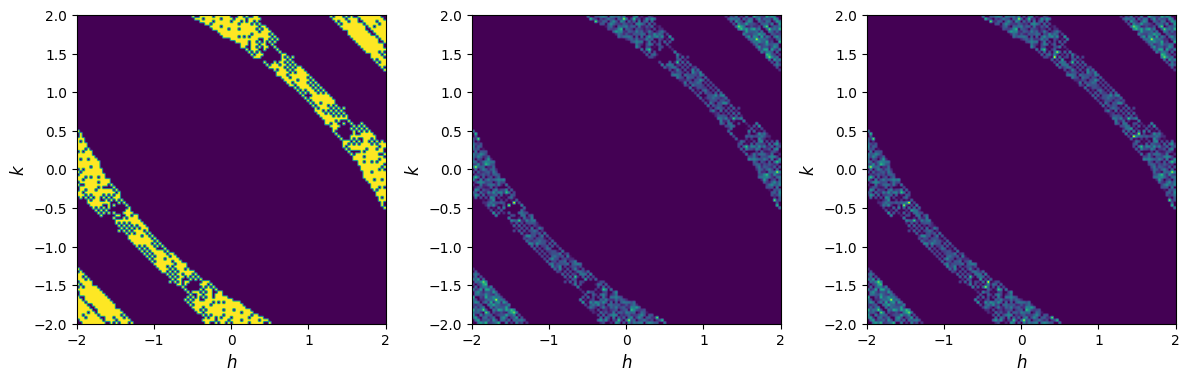

In [239]:
# background is those where experiment coverage is available (first)
# while no magnetic signal is present (second)
mask_background = (neutron_exp.Sqw.cpu().numpy() > 1e-10) * (s_pred <= 1e-4*s_pred.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(mask_background[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)
ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy() * mask_background)[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)
ax = axes[2]
ax.imshow((neutron_exp.Sqw.cpu().numpy())[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

In [240]:
total_signal = neutron_exp.Sqw.cpu().numpy()

# s_pred_masked_sm = gaussian_filter(s_pred_masked, sigma=0.75)
# s_pred_masked

In [241]:
q_inner_mid = 1.1441
q_mid_outer = 1.8512

mask_inner = (hklw_grid_norm <= q_inner_mid).numpy() * mask_pred
mask_mid = (hklw_grid_norm >  q_inner_mid).numpy() * (hklw_grid_norm <=  q_mid_outer).numpy() * mask_pred
mask_outer = (hklw_grid_norm >  q_mid_outer).numpy() * mask_pred

In [242]:
scale_factor_list = np.linspace(0.1, 4, 50)
inner_pc_sim_list = []
mid_pc_sim_list = []
outer_pc_sim_list = []

for scale_factor in tqdm(scale_factor_list):
    inner_pc_sim_list.append(pearsonr(s_pred_masked_sm[mask_inner], total_signal[mask_inner] - scale_factor * s_pred_masked_sm[mask_inner]).statistic)
    mid_pc_sim_list.append(pearsonr(s_pred_masked_sm[mask_mid], total_signal[mask_mid] - scale_factor * s_pred_masked_sm[mask_mid]).statistic)
    outer_pc_sim_list.append(pearsonr(s_pred_masked_sm[mask_outer], total_signal[mask_outer] - scale_factor * s_pred_masked_sm[mask_outer]).statistic)
    
inner_pc_sim_list = np.asarray(inner_pc_sim_list)
mid_pc_sim_list = np.asarray(mid_pc_sim_list)
outer_pc_sim_list = np.asarray(outer_pc_sim_list)
# for scale_factor in tqdm(scale_factor_list):
#     inner_bkg = total_signal[mask_inner] - scale_factor * s_pred_masked_sm[mask_inner]
#     inner_peak = total_signal[mask_inner] - inner_bkg
#     inner_pc_sim_list.append(pearsonr(s_pred_masked_sm[mask_inner], inner_peak).statistic)
    
#     mid_bkg = total_signal[mask_mid] - scale_factor * s_pred_masked_sm[mask_mid]
#     mid_peak = total_signal[mask_mid] - mid_bkg
#     mid_pc_sim_list.append(pearsonr(s_pred_masked_sm[mask_mid], mid_peak).statistic)
    
    
#     outer_bkg = total_signal[mask_outer] - scale_factor * s_pred_masked_sm[mask_outer]
#     outer_peak = total_signal[mask_outer] - outer_bkg
#     outer_pc_sim_list.append(pearsonr(s_pred_masked_sm[mask_outer], outer_peak).statistic)

100%|██████████| 50/50 [00:03<00:00, 14.20it/s]


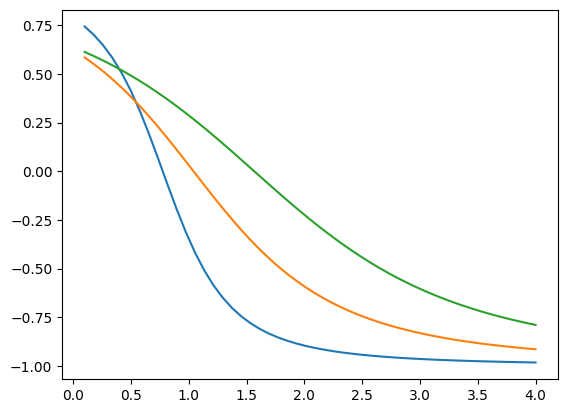

In [243]:
# plt.plot(scale_factor_list, pc_exp_list)
plt.plot(scale_factor_list, inner_pc_sim_list)
plt.plot(scale_factor_list, mid_pc_sim_list)
plt.plot(scale_factor_list, outer_pc_sim_list)

In [244]:
inner_pc_func = interp1d(scale_factor_list, inner_pc_sim_list)
mid_pc_func = interp1d(scale_factor_list, mid_pc_sim_list)
outer_pc_func = interp1d(scale_factor_list, outer_pc_sim_list)

In [245]:
opt_inner_scale_factor = fsolve(inner_pc_func, 2.5)
print("best scale factor for inner q-region: ", opt_inner_scale_factor)
opt_mid_scale_factor = fsolve(mid_pc_func, 2.5)
print("best scale factor for mid q-region: ", opt_mid_scale_factor)
try:
    opt_outer_scale_factor = fsolve(outer_pc_func, 2.5)
except:
    opt_outer_scale_factor = 0.
print("best scale factor for outer q-region: ", opt_outer_scale_factor)

ValueError: A value (-13.805089287238982) in x_new is below the interpolation range's minimum value (0.1).

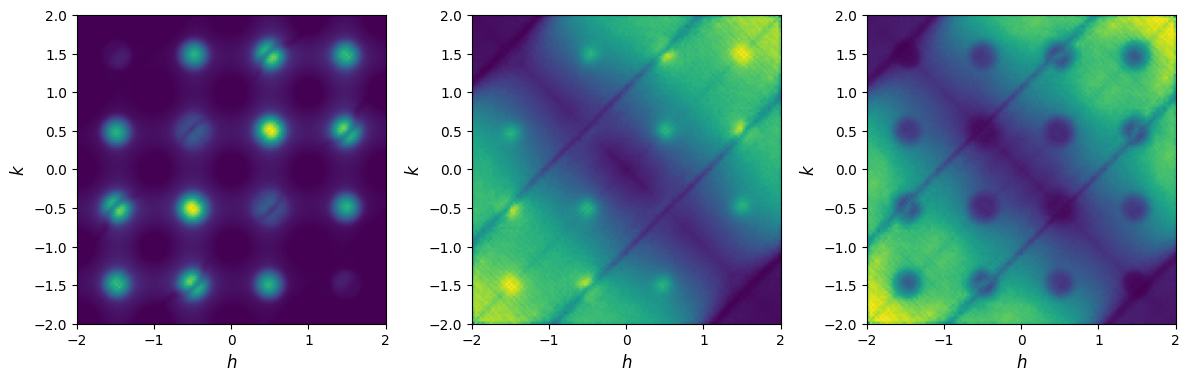

In [ ]:
background = total_signal.copy()
background[mask_inner] = total_signal[mask_inner] - opt_inner_scale_factor/1 * s_pred_masked_sm[mask_inner]
background[mask_mid] = total_signal[mask_mid] - opt_mid_scale_factor/1 * s_pred_masked_sm[mask_mid]
background[mask_outer] = total_signal[mask_outer] - opt_outer_scale_factor/1 * s_pred_masked_sm[mask_outer]


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked_sm.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow(background.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


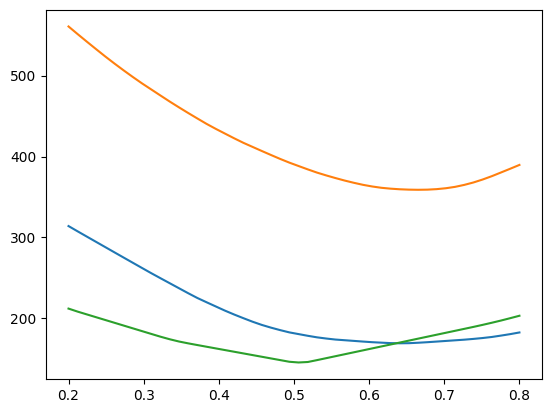

In [ ]:
sub_scale_factor = np.linspace(0.2, 0.8, 50)
ddv_inner = np.zeros_like(sub_scale_factor)
ddv_mid = np.zeros_like(sub_scale_factor)
ddv_outer = np.zeros_like(sub_scale_factor)

mask_pred_sum = ((s_pred_sm > 2.5e-1*s_pred_sm.max()) * mask_exp.cpu().numpy()).sum(-1).sum(-1)
_mask = mask_pred_sum[1:-1,1:-1] > 0

mask_inner_sum = (mask_inner.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0
mask_mid_sum = (mask_mid.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0
mask_outer_sum = (mask_outer.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0

for i_scale_factor, _scale_factor in tqdm(enumerate(sub_scale_factor), total=len(sub_scale_factor)):

    background = total_signal.copy()
    background[mask_inner] = total_signal[mask_inner] - _scale_factor * opt_inner_scale_factor * s_pred_masked_sm[mask_inner]
    background[mask_mid] = total_signal[mask_mid] - _scale_factor * opt_mid_scale_factor * s_pred_masked_sm[mask_mid]
    background[mask_outer] = total_signal[mask_outer] - _scale_factor * opt_outer_scale_factor * s_pred_masked_sm[mask_outer]

    background_hk = background.sum(-1).sum(-1)
    
    # background_hk_dh = background_hk[2:,1:-1] - 2*background_hk[1:-1,1:-1] + background_hk[:-2,1:-1]
    # background_hk_dk = background_hk[1:-1,2:] - 2*background_hk[1:-1,1:-1] + background_hk[1:-1,:-2]
    
    background_hk_dh = background_hk[2:,1:-1] - background_hk[:-2,1:-1]
    background_hk_dk = background_hk[1:-1,2:] - background_hk[1:-1,:-2]
    
    ddv_inner[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_inner_sum].mean()
    ddv_mid[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_mid_sum].mean()
    ddv_outer[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_outer_sum].mean()
plt.plot(sub_scale_factor, ddv_inner, '-')
plt.plot(sub_scale_factor, ddv_mid, '-')
plt.plot(sub_scale_factor, ddv_outer, '-')

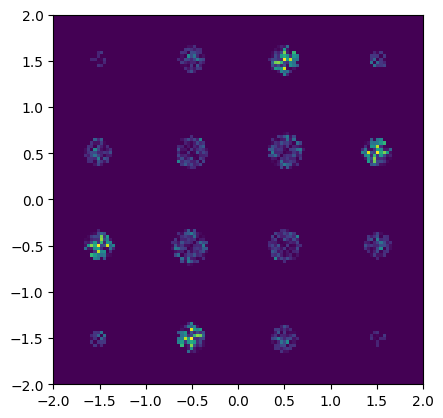

In [ ]:
best_sub_inner_scale_factor = sub_scale_factor[np.argmin(ddv_inner)]
best_sub_mid_scale_factor = sub_scale_factor[np.argmin(ddv_mid)]
best_sub_outer_scale_factor = sub_scale_factor[np.argmin(ddv_outer)]
# best_sub_scale_factor = 1

background = total_signal.copy()
background[mask_inner] = total_signal[mask_inner] - best_sub_inner_scale_factor * opt_inner_scale_factor * s_pred_masked_sm[mask_inner]
background[mask_mid] = total_signal[mask_mid] - best_sub_mid_scale_factor * opt_mid_scale_factor * s_pred_masked_sm[mask_mid]
background[mask_outer] = total_signal[mask_outer] - best_sub_outer_scale_factor * opt_outer_scale_factor * s_pred_masked_sm[mask_outer]

background_hk = background.sum(-1).sum(-1)

background_hk_dh = background_hk[2:,1:-1] - 2*background_hk[1:-1,1:-1] + background_hk[:-2,1:-1]
background_hk_dk = background_hk[1:-1,2:] - 2*background_hk[1:-1,1:-1] + background_hk[1:-1,:-2]

plt.imshow((np.abs(background_hk_dh - background_hk_dk) * _mask).T, origin='lower', extent=[-2, 2, -2, 2])

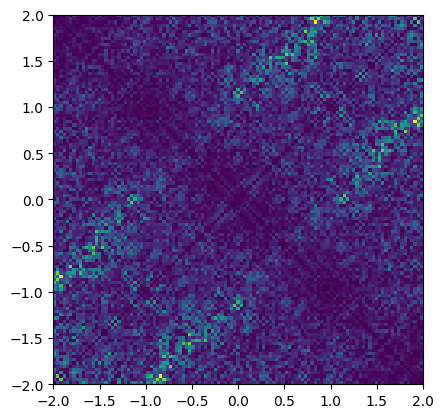

In [ ]:
plt.imshow(np.abs(background_hk_dh - background_hk_dk)[2:-2,2:-2].T, origin='lower', extent=[-2, 2, -2, 2])

In [ ]:
cmap = sns.color_palette("ch:s=.5,rot=-.5_r", as_cmap=True)

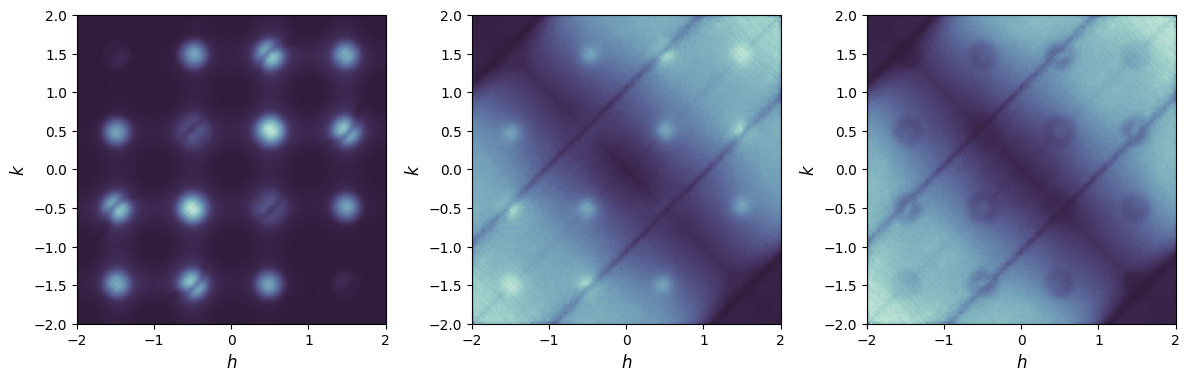

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked_sm.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow(background.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

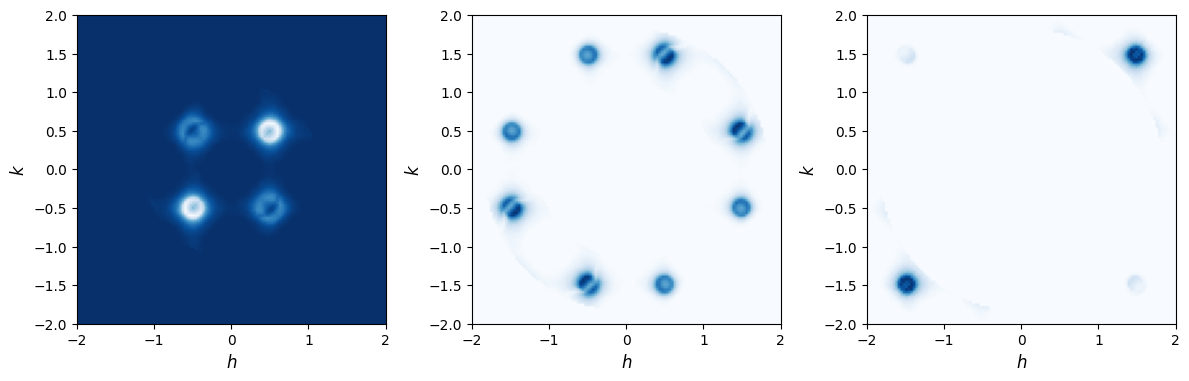

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(mask_inner.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow(mask_mid.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap='Blues')
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[2]
ax.imshow(mask_outer.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap='Blues')
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

In [30]:
data_w_bkg = {key: val for (key, val) in data.items()}

In [31]:
data_w_bkg['background'] = background

In [32]:
data_w_bkg['scale'] = {key: {'scale_factor': None, 'scale_mask': None} for key in ['inner', 'mid', 'outer']}

In [33]:
for key in data_w_bkg['scale'].keys():
    data_w_bkg['scale'][key]['scale_factor'] = eval(f'opt_{key}_scale_factor[0]')
    data_w_bkg['scale'][key]['scale_mask'] = eval(f'torch.from_numpy(mask_{key})')

In [34]:
data_w_bkg['scale_separator'] = {'inner_mid': q_inner_mid, 'mid_outer': q_mid_outer}

In [35]:
# torch.save(data_w_bkg, f'/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_w_bkg_{incident_energy:d}meV.pt')